_Version log: Finding the best samples though brute force and manual tweaking_

In [20]:
import CS_functions as cs
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt, colors as mplcolors
plt.rcParams.update({'font.size':16})
#np.set_printoptions(threshold=sys.maxsize)

In [21]:
file_name = "1dmockanderrors12"
file_type = ".csv"
reduced_points = 4

target, uncertainties = cs.open_dataset(file_name, file_type)
#uncertainties = np.ones_like(uncertainties)
total_points = len(target)
optlocs_file = "data\\" + file_name +"_optlocs.csv"

In [22]:
full_data = cs.open_csv(optlocs_file, reduced_points)

In [31]:
#test = [11,15,24,27,44,66,85,126] #PCA
#test = [72,76,79,89,96,100,107,117] #RPCA
#test = [0,88,94,100,104,124,165,190] #[31,55,62,70,79,83,93,100,104,111,125,132,139,149,159,197] # Manual
#test = [41,42,45,46,58,59,63,65] # SA
#test = [18,36,52,56,59,71,77,86] #MCMC
test = [90,92,94,96] #Brute force
#test = cs.subsample_1d(total_points, reduced_points, subsampling_method= "regular") # referance

test = np.array(test)

len(test)

4

In [32]:
np.diff(test)

array([2, 2, 2])

In [33]:
full_data = np.vstack([full_data, test])
full_data.shape

(26, 4)

In [34]:
regularization_coeffient = 1e-4

def find_error(locations):
    assert locations.ndim == 1
    locations = locations[~np.isnan(locations)].astype(int)

    samples = np.full_like(target, np.nan)
    samples[locations] = target[locations]
    result = cs.compressed_sensing(samples, regularization_coeffient)
    error = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared

    return error

errors = [find_error(locations) for locations in tqdm(full_data)]
errors = np.array(errors)


100%|██████████| 26/26 [00:00<00:00, 121.03it/s]


In [35]:
sort = np.argsort(errors)
print(errors[-1])
errors = errors[sort]
full_data = full_data[sort]

0.9477074614100814


In [36]:
print(*zip(errors, full_data), sep= "\n")

(0.9477074614100814, array([90, 92, 94, 96]))
(0.9477074614100814, array([90, 92, 94, 96]))
(1.2669920010895135, array([ 89,  96,  99, 104]))
(1.267250978659425, array([90, 93, 95, 96]))
(1.2716643340599998, array([ 90,  93,  96, 108]))
(1.4187831833604072, array([ 90,  93,  96, 122]))
(1.5142058539766168, array([ 89, 102, 104, 173]))
(1.5718533798397112, array([  2,   9, 102, 104]))
(1.5718533798397112, array([  2,   9, 102, 104]))
(1.579784252214213, array([ 19,  95,  97, 110]))
(2.045132591588755, array([  0,  26, 102, 104]))
(2.4957531039224627, array([ 96,  98, 161, 196]))
(2.6576598177636486, array([ 90, 102, 104, 145]))
(2.704278140487672, array([110, 112, 133, 192]))
(2.943489046786432, array([ 15,  45, 109, 111]))
(2.9659763201264018, array([ 21, 109, 111, 165]))
(3.672839288438776, array([ 13,  47, 129, 169]))
(3.7249184344434023, array([ 51,  75, 127, 148]))
(3.72621737277258, array([  4,  33, 131, 135]))
(3.7297609058810823, array([ 65, 135, 142, 152]))
(3.7512363744301602,

In [37]:
sa_error = find_error(test)
brute_errors = np.empty((reduced_points, total_points))

fixed_points = np.repeat(test[None, :], reduced_points, axis= 0)
fixed_points = fixed_points[~np.eye(reduced_points, dtype= bool)] #one of the samples is not fixed
fixed_points = fixed_points.reshape((reduced_points, reduced_points-1)) #tell numpy to stop flattening my array

for n in np.arange(reduced_points):
    trail_samples = np.copy(test)
    for trail_sample in np.arange(total_points):
        trail_samples[n] = trail_sample
        brute_error = find_error(trail_samples) #This is the chi-squared
        brute_errors[n, trail_sample] = brute_error

0.0


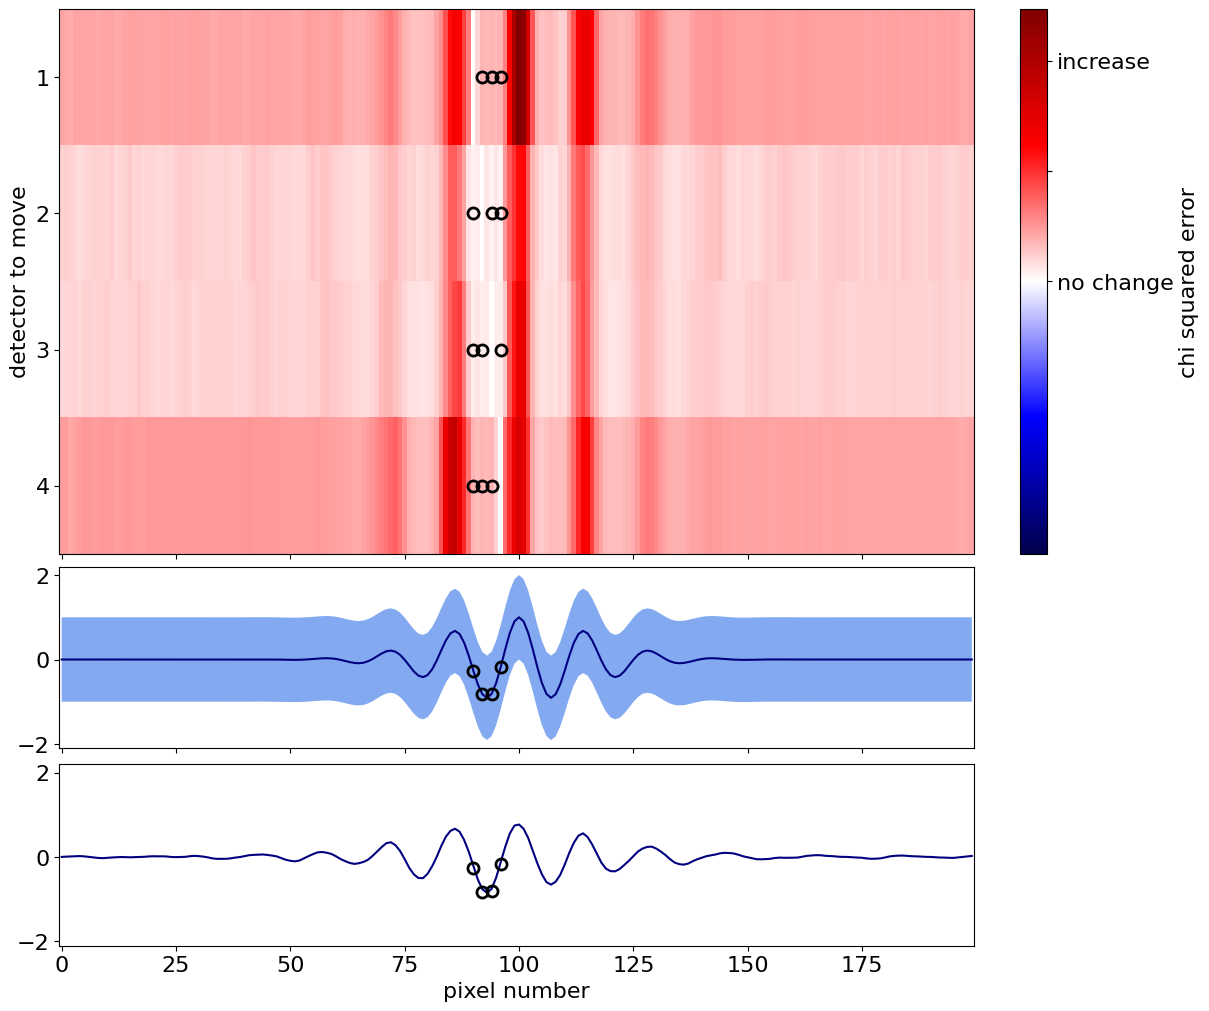

In [38]:
difference = brute_errors -sa_error

max_diff = np.max(difference)
min_diff = np.min(difference)
print(min_diff) # If this is less than zero then SA failed to find the best solution.
if min_diff >= 0: min_diff = -1 #If this is more than or equal to zero then my code breaks!

pos_zticks = np.arange(0, max_diff, 10**np.floor(np.log10(np.abs(max_diff))))
neg_zticks = np.arange(0, min_diff, -10**np.floor(np.log10(np.abs(min_diff)))) # np.floor() is NOT the same as int() for negative numbers!
zticks = np.unique(np.concatenate([pos_zticks, neg_zticks]))

zticklabels = np.full_like(zticks, "", dtype= object)
zticklabels[0] = "decrease"
zticklabels[-1] = "increase"
zticklabels[zticks == 0] = "no change"

fig, axs = plt.subplots(3, 1, figsize= (12, 10), sharex= True, height_ratios= (3, 1, 1), layout= "constrained")

norm = mplcolors.TwoSlopeNorm(0, vmin=min_diff, vmax=max_diff) #Greatly exagerates the possible improvements
im = axs[0].imshow(difference, aspect= "auto", interpolation= "none", cmap= "seismic", norm= norm)
cbar = fig.colorbar(im, label= "chi squared error")
cbar.set_ticks(ticks= zticks, labels=zticklabels)

axs[0].plot(fixed_points ,np.arange(reduced_points), linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8) #kind of cursed but it works
axs[0].set(ylabel= "detector to move", yticks= np.arange(reduced_points), yticklabels= np.arange(1, reduced_points+1))

axs[1].plot(target, color= "navy", label= "actual signal")
axs[1].fill_between(range(total_points), target-uncertainties, target+uncertainties, facecolor= "cornflowerblue", alpha= 0.8, label= "± std uncertrainty")
axs[1].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8)

samples = np.full_like(target, np.nan)
samples[test] = target[test]

axs[2].plot(cs.compressed_sensing(samples, regularization_coeffient), color= "navy")
axs[2].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8)
axs[2].set(xlabel= "pixel number", ylim= axs[1].get_ylim())

plt.show()